# Project 1 MLP --- train part

In [15]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from collections import defaultdict
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define hyperparameters
batch_size = 100
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-08
num_epochs = 100
n_epochs_stop = 5
early_stop = False

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations #with data augmentation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
transform_augment = transforms.Compose([
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Downloading the datasets
full_train_dataset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform_augment)
test_dataset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

# Creating a validation split
train_dataset, val_dataset = random_split(full_train_dataset, [50000, 10000])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Data batch shape: torch.Size([100, 1, 28, 28])


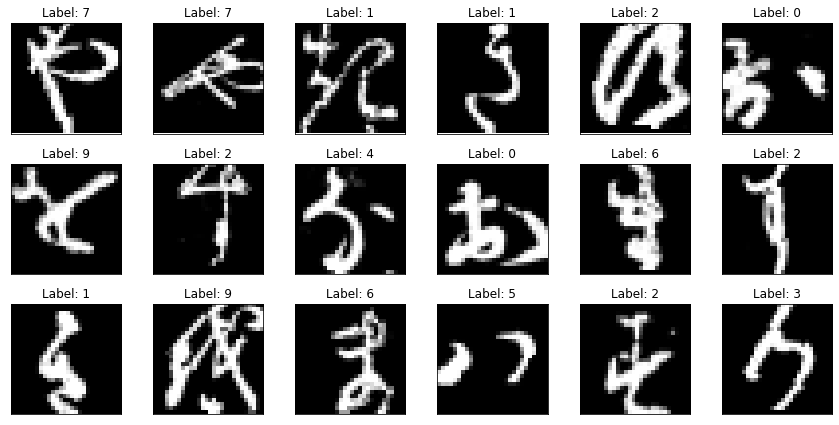

In [3]:
import matplotlib.pyplot as plt

# Load one batch of images along with their labels
dataiter = iter(train_loader)
images, labels = next(dataiter) 

num_images = min(18, len(images))

# Print the shape of the data batch - useful for debugging
print(f'Data batch shape: {images.shape}')

# Create figure for plotting
fig = plt.figure(figsize=(12, 6))

# Plot the images from the batch
for index in range(num_images):
    ax = fig.add_subplot(3, 6, index + 1, xticks=[], yticks=[])
    npimg = images[index].squeeze().numpy()
    # npimg = np.transpose(npimg, (1, 2, 0))  # If the image is not grayscale
    npimg = npimg * 0.5 + 0.5  # Un-normalize the image
    ax.imshow(npimg, cmap='gray')  
    # Display the corresponding label below each image
    ax.set_title(f'Label: {labels[index]}')

# Show the figure holding the subplots
plt.tight_layout()
plt.show()


# Check data split

In [4]:
# Check the length of the datasets
print(f"Full training dataset size: {len(full_train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Create a validation set from the full training dataset
train_dataset, val_dataset = random_split(full_train_dataset, [50000, 10000])  # Splitting the training dataset

# Check the sizes of the split datasets
print(f"After split - Training dataset size: {len(train_dataset)}")
print(f"After split - Validation dataset size: {len(val_dataset)}")

Full training dataset size: 60000
Test dataset size: 10000
After split - Training dataset size: 50000
After split - Validation dataset size: 10000


In [5]:
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

#test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# MLP Model

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.flatten = nn.Flatten()

        # First hidden layer: 784 -> 512
        self.fc1 = nn.Linear(784, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')

        # Second hidden layer: 512 -> 256
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')

        # Output layer: 256 -> 10
        self.fc3 = nn.Linear(256, 10)
        init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')

    def forward(self, x):
        x = self.flatten(x)
        
        # First hidden layer
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        # Second hidden layer
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        # Output layer
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)


# Model Criterion and optimizer

In [7]:
# Initialize the model, criterion, and optimizer
model = MLP().to(device)  # No hidden_sizes parameter required
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, beta2), eps=epsilon)

num_epochs = 100
n_epochs_stop = 5
early_stop = False

# Training function

In [8]:
# Function for training or evaluation
from collections import defaultdict
def run_epoch(loader, model, criterion, optimizer=None, device=device):
    is_training = optimizer is not None
    
    # Store performance data
    epoch_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Set model mode
    if is_training:
        model.train()
    else:
        model.eval()

    for batch in loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU, if available

        # Reset gradients
        if is_training:
            optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()  # Accumulate loss

        # Backward pass and optimization
        if is_training:
            loss.backward()
            optimizer.step()

        # Calculate correct predictions
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    # Calculate average loss and accuracy
    avg_loss = epoch_loss / len(loader)
    accuracy = (correct_predictions / total_predictions) * 100.0

    return avg_loss, accuracy

# Training and Validation Set

In [9]:
from copy import deepcopy
import torch.nn.functional as F


performance_tracking = defaultdict(list)
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_params = deepcopy(model.state_dict())

# We will also store the best model parameters corresponding to the best validation loss
best_model_params = deepcopy(model.state_dict())

for epoch in range(num_epochs):
    # Training
    train_loss, train_accuracy = run_epoch(train_loader, model, criterion, optimizer, device=device)
    
    # Validation
    val_loss, val_accuracy = run_epoch(val_loader, model, criterion, device=device)  # No optimizer passed in validation

    # Store performance data
    performance_tracking['train_loss'].append(train_loss)
    performance_tracking['train_accuracy'].append(train_accuracy)
    performance_tracking['val_loss'].append(val_loss)
    performance_tracking['val_accuracy'].append(val_accuracy)

    # Print statistics
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    # Early Stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_params = deepcopy(model.state_dict())  # save the better model parameters
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print('Early stopping!')
            early_stop = True
            model.load_state_dict(best_model_params)  # restore best model
            break  # break the training loop

    print('---------------------------------------')

# If early stopping did not occur, load the best model parameters found during training
if not early_stop:
    model.load_state_dict(best_model_params)


Epoch 1/100
Train Loss: 0.7502, Train Accuracy: 75.95%
Validation Loss: 0.4261, Validation Accuracy: 86.44%
---------------------------------------
Epoch 2/100
Train Loss: 0.4645, Train Accuracy: 85.24%
Validation Loss: 0.3306, Validation Accuracy: 89.81%
---------------------------------------
Epoch 3/100
Train Loss: 0.3933, Train Accuracy: 87.56%
Validation Loss: 0.2828, Validation Accuracy: 91.20%
---------------------------------------
Epoch 4/100
Train Loss: 0.3480, Train Accuracy: 89.06%
Validation Loss: 0.2556, Validation Accuracy: 92.19%
---------------------------------------
Epoch 5/100
Train Loss: 0.3297, Train Accuracy: 89.51%
Validation Loss: 0.2281, Validation Accuracy: 93.08%
---------------------------------------
Epoch 6/100
Train Loss: 0.2943, Train Accuracy: 90.61%
Validation Loss: 0.2191, Validation Accuracy: 93.06%
---------------------------------------
Epoch 7/100
Train Loss: 0.2815, Train Accuracy: 91.17%
Validation Loss: 0.1995, Validation Accuracy: 93.80%
----

In [10]:
# Save the trained model
torch.save(model.state_dict(), 'model.pth')

In [16]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score


# Binarize the labels
test_true_labels_bin = label_binarize(test_true_labels, classes=[i for i in range(10)])
test_probs_np = np.array(test_probs)

# For each class, compute precision and recall
precision = {}
recall = {}
average_precision = {}
for i in range(10):
    precision[i], recall[i], _ = precision_recall_curve(test_true_labels_bin[:, i], test_probs_np[:, i])
    average_precision[i] = average_precision_score(test_true_labels_bin[:, i], test_probs_np[:, i])


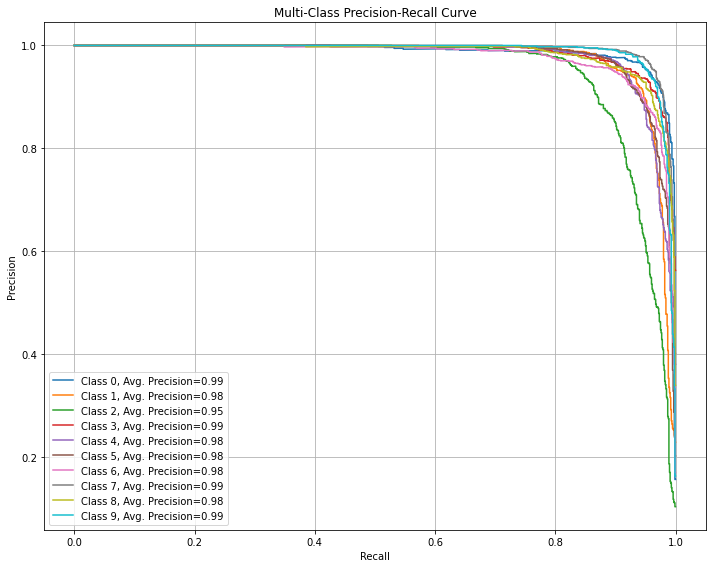

In [17]:
plt.figure(figsize=(10, 8))

# For each class
for i in range(10):
    plt.plot(recall[i], precision[i], label=f"Class {i}, Avg. Precision={average_precision[i]:.2f}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-Class Precision-Recall Curve')
plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.show()


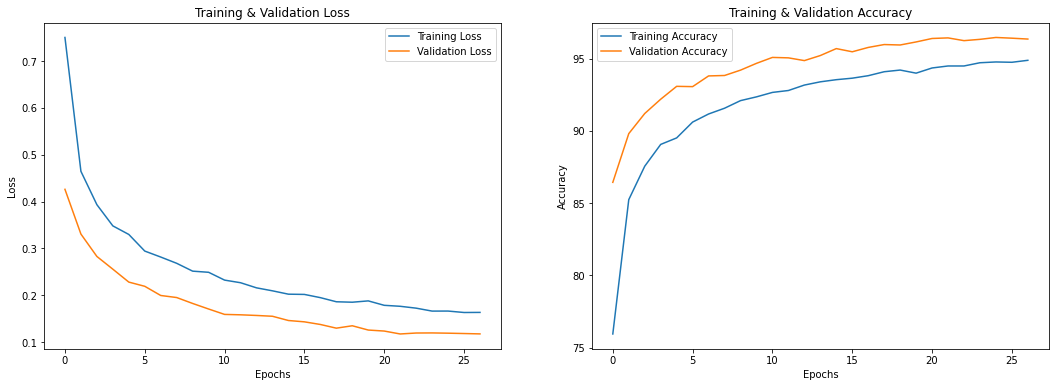

In [18]:
# Importing required libraries for plotting
import matplotlib.pyplot as plt

# Extracting values from the performance tracking
train_loss = performance_tracking['train_loss']
val_loss = performance_tracking['val_loss']
train_accuracy = performance_tracking['train_accuracy']
val_accuracy = performance_tracking['val_accuracy']

# Creating subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plotting training and validation loss
ax1.plot(train_loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training & Validation Loss')
ax1.legend()

# Plotting training and validation accuracy
ax2.plot(train_accuracy, label='Training Accuracy')
ax2.plot(val_accuracy, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training & Validation Accuracy')
ax2.legend()

# Show plots
plt.show()


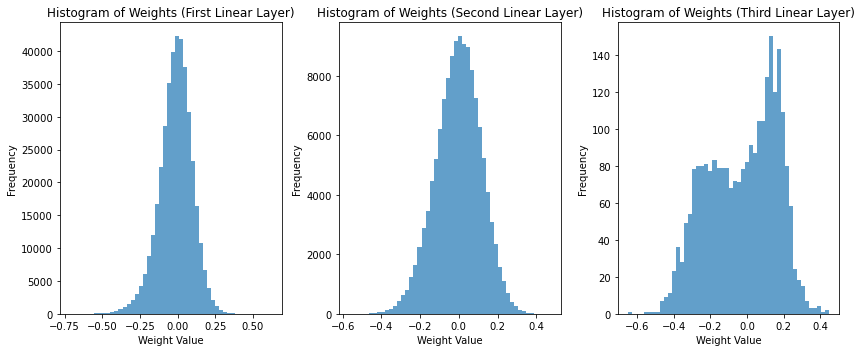

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Extract weights for each layer
weights_fc1 = model.fc1.weight.detach().cpu().numpy()
weights_fc2 = model.fc2.weight.detach().cpu().numpy()
weights_fc3 = model.fc3.weight.detach().cpu().numpy()

# Create histograms for each layer
plt.figure(figsize=(12, 5))
plt.subplot(131)
plt.hist(weights_fc1.flatten(), bins=50, alpha=0.7)
plt.title('Histogram of Weights (First Linear Layer)')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(132)
plt.hist(weights_fc2.flatten(), bins=50, alpha=0.7)
plt.title('Histogram of Weights (Second Linear Layer)')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(133)
plt.hist(weights_fc3.flatten(), bins=50, alpha=0.7)
plt.title('Histogram of Weights (Third Linear Layer)')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
